In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import summary_meta_validation, probability_meta_validation, DEFAULT_KEYS
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.visualization import perf_tester

import numpy as np
import bayesflow as bf
import tensorflow as tf
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load network

In [2]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_1']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_1']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_1']['dense_equiv_args']), 
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_2']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_2']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_2']['dense_equiv_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                   dense_args=probability_meta_validation['dense_args'], 
                                                   dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, 
                                                   summary_net, 
                                                   loss_fun=partial(bf.losses.log_loss, label_smoothing=None))

In [3]:
# Training steps
epochs = 40 
iterations_per_epoch = 1000

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    default_lr=0.0002,
    checkpoint_path=checkpoint_path
    )

# Sample size
n_clusters = 25
n_obs = 50

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\history_40.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\ckpt-40


# Get OOD score

## Utility functions

In [4]:
def noise_simulator(batch_size, n_clusters=25, n_obs=50, RNG=None, **kwargs):
    """ Generates a single hierarchical data set. """
    if RNG is None:
        RNG = np.random.default_rng()
    data = RNG.integers(low=0, high=2, size=(batch_size, n_clusters, n_obs, 2)) 
    #data = RNG.integers(low=-100, high=101, size=(batch_size, n_clusters, n_obs, 2))

    out_dict = {
        DEFAULT_KEYS["sim_data"]: data,
    }

    return out_dict

In [5]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)
mpt_simulator = partial(sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs, n_vars=2)

In [6]:
def get_max_activation(data, probability_net, summary_net, method):
    """ Gets the inference networks' last-layer-activation, either before or after 
    passing it through the softmax function. """

    if method=='max_softmax':
        activations = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(data, 20)])
    if method=='max_logits':
        activations = np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(data, 20)])
          
    max_activation = np.max(activations, axis=1)

    return max_activation

## Data generation

In [7]:
num_data_sets = 5000

sdt_data = sdt_simulator(num_data_sets)['sim_data']
mpt_data = mpt_simulator(num_data_sets)['sim_data']
noise_data = noise_simulator(num_data_sets)['sim_data']

## max_softmax

In [8]:
sdt_max_softmax = get_max_activation(sdt_data, probability_net, summary_net, 'max_softmax')
mpt_max_softmax = get_max_activation(mpt_data, probability_net, summary_net, 'max_softmax')
noise_max_softmax = get_max_activation(noise_data, probability_net, summary_net, 'max_softmax')
print(np.mean(sdt_max_softmax), np.mean(mpt_max_softmax), np.mean(noise_max_softmax))

0.94373065 0.9288032 0.9987872


In [9]:
def get_percentage_rejected(model_activations, noise_activations, ci=[0.025, 0.975]):

    proportions_rejected = []

    for activations in model_activations:
        lower_threshold, upper_threshold = np.quantile(activations, q=ci, axis=0)
        print(lower_threshold, upper_threshold)
        print(np.max(noise_activations))
        rejected = np.logical_or(noise_activations < lower_threshold, noise_activations > upper_threshold)
        proportion_rejected = np.sum(rejected) / len(noise_activations)
        proportions_rejected.append(proportion_rejected)

    return proportions_rejected

get_percentage_rejected([sdt_max_softmax, mpt_max_softmax], noise_max_softmax)

0.5632180988788604 0.9999995231628418
0.9999976
0.5699418544769287 0.9999673396348954
0.9999976


[0.0, 0.1756]

Text(0.5, 1.0, 'MaxSoftmax')

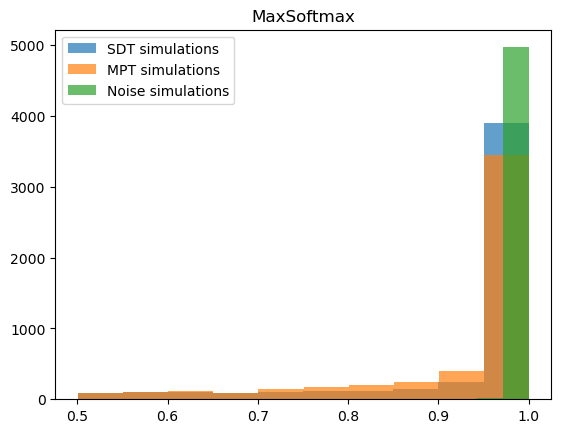

In [11]:
plt.hist(sdt_max_softmax, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_softmax, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_softmax, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxSoftmax')

## max_logits

In [12]:
#import tensorflow as tf
#tf.random.set_seed(2023) 
# fixes wildly differing results - but why are they so different when reloading the net in the first place??

sdt_max_logits = get_max_activation(sdt_data, probability_net, summary_net, 'max_logits')
mpt_max_logits = get_max_activation(mpt_data, probability_net, summary_net, 'max_logits')
noise_max_logits = get_max_activation(noise_data, probability_net, summary_net, 'max_logits')
print(np.mean(sdt_max_logits), np.mean(mpt_max_logits), np.mean(noise_max_logits))

3.1558604 2.1643002 4.0962944


In [13]:
get_percentage_rejected([sdt_max_logits, mpt_max_logits], noise_max_logits)

0.056539016216993365 6.854201066493987
6.150418
0.06330489739775658 4.480452370643616
6.150418


[0.0, 0.3658]

Text(0.5, 1.0, 'MaxLogit')

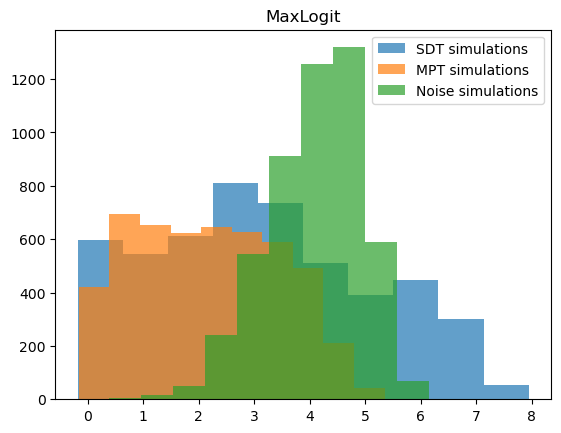

In [14]:
plt.hist(sdt_max_logits, alpha=0.7, label='SDT simulations')
plt.hist(mpt_max_logits, alpha=0.7, label='MPT simulations')
plt.hist(noise_max_logits, alpha=0.7, label='Noise simulations')
plt.legend()
plt.title('MaxLogit')

# Inspect predictions 

## SDT MPT data

ECE = 0.013


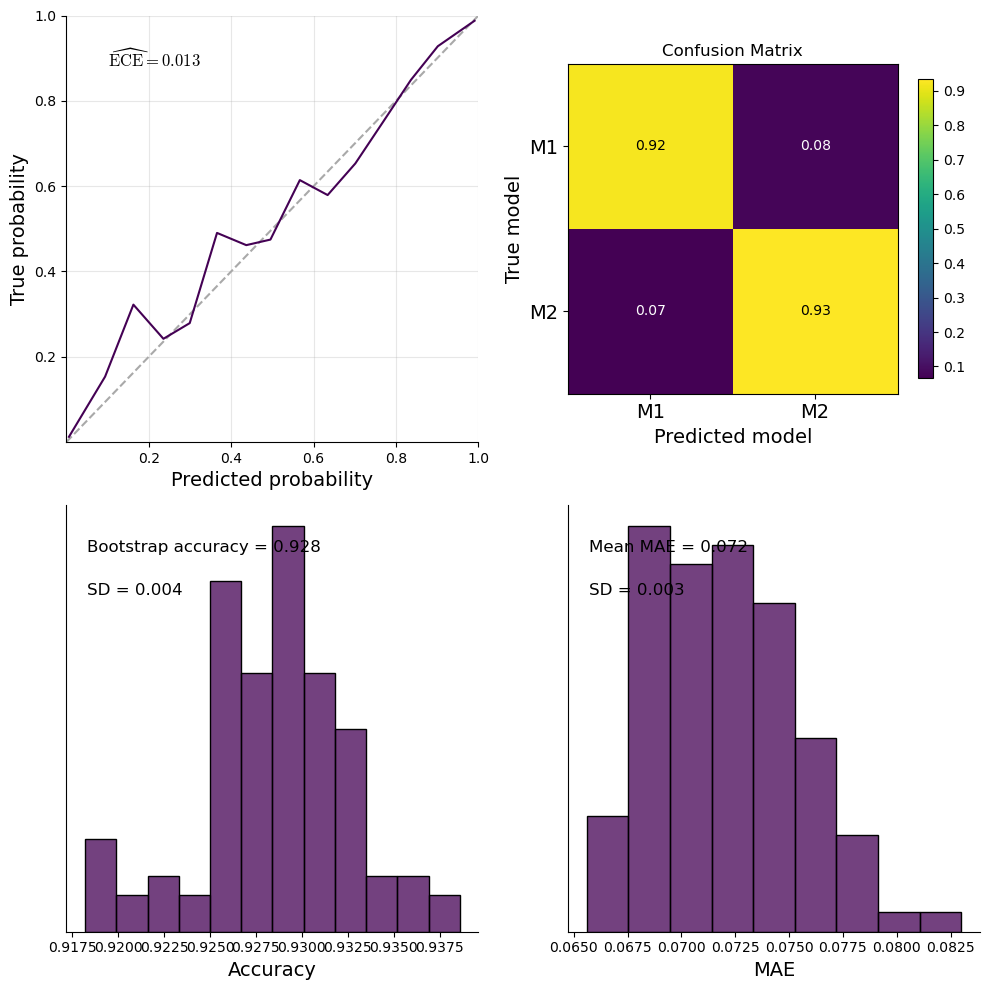

In [15]:
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

## Noisy data

ECE = 0.496


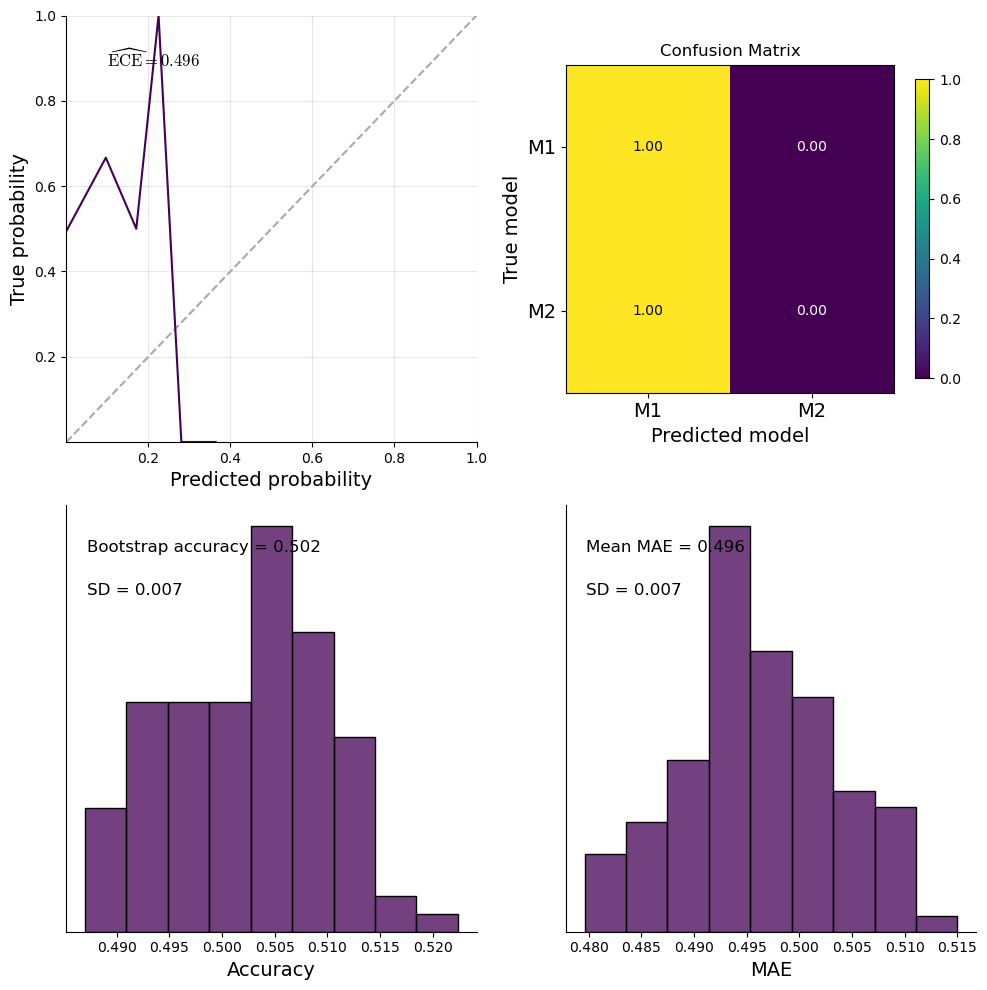

In [16]:
meta_noise = bf.simulation.MultiGenerativeModel([noise_simulator,noise_simulator])
val_data = trainer.configurator(meta_noise(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

In [17]:
# check that both columns of simulated noise data are random
np.mean(noise_data, axis=(0,1,2))

array([0.50016112, 0.5001768 ])

In [18]:
# inspect predictions
noise_softmax = np.concatenate([probability_net.posterior_probs(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_softmax, axis=0)

array([0.99871653, 0.00129733], dtype=float32)

In [19]:
noise_softmax[:10,:]

array([[0.999949  , 0.000051  ],
       [0.9999523 , 0.00004773],
       [0.9999167 , 0.00008333],
       [0.9999683 , 0.00003169],
       [0.9999933 , 0.00000665],
       [0.99997544, 0.00002451],
       [0.99996316, 0.00003683],
       [0.99994576, 0.00005422],
       [0.99997485, 0.00002509],
       [0.9999682 , 0.00003186]], dtype=float32)

In [20]:
# inspect logits
noise_logits=np.concatenate([probability_net.logits(summary_net(chunk)) for chunk in tf.split(noise_data, 20)])
np.mean(noise_logits, axis=0)

array([ 4.0961113, -4.5345263], dtype=float32)

In [21]:
noise_logits[:10,:]

array([[ 4.663022 , -5.220687 ],
       [ 4.7033353, -5.246525 ],
       [ 4.4386625, -4.953914 ],
       [ 4.9058414, -5.4536514],
       [ 5.6511436, -6.2694397],
       [ 5.0018783, -5.614618 ],
       [ 4.8265347, -5.382602 ],
       [ 4.646051 , -5.176431 ],
       [ 5.026191 , -5.5666766],
       [ 4.9021225, -5.4518924]], dtype=float32)

# Generate and save test data for comparison with bridge sampling

In [22]:
n_data_sets = 100
n_clusters = 25
n_obs = 50

noise_data_ood = noise_simulator(n_data_sets, RNG=np.random.default_rng(2023))['sim_data']

In [23]:
# save data sets
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

#np.save(os.path.join(val_folder, 'noise_data_ood'), noise_data_ood)

# Compare predictions

In [24]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2023_06_16_BF_BS_ood'
bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN = probability_net.posterior_probs(summary_net(noise_data_ood))

results_list = [bridge, NN]

In [25]:
NN_array = np.array(NN[:, 0])

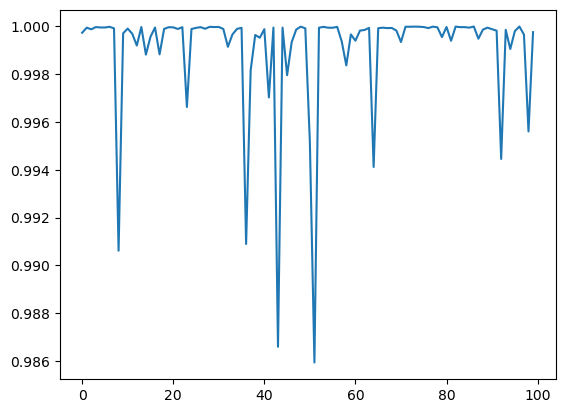

In [26]:
plt.plot(NN_array)

In [27]:
bridge_array = np.array(bridge.loc[:, "m0_prob"])

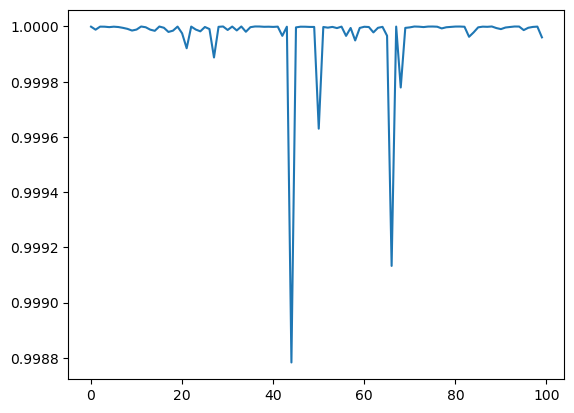

In [28]:
plt.plot(bridge_array)

In [29]:
NN_array

array([0.99972695, 0.99994063, 0.9998721 , 0.99996555, 0.99994814,
       0.9999473 , 0.9999763 , 0.9999124 , 0.9906136 , 0.9997044 ,
       0.9999014 , 0.99968624, 0.99919397, 0.9999671 , 0.99881315,
       0.9995567 , 0.99994504, 0.9988249 , 0.9998894 , 0.9999589 ,
       0.99995375, 0.99988544, 0.9999608 , 0.99662316, 0.999884  ,
       0.9999318 , 0.99996233, 0.9998945 , 0.9999753 , 0.9999659 ,
       0.9999695 , 0.9998858 , 0.9991398 , 0.9996568 , 0.99988925,
       0.9999343 , 0.9908947 , 0.9981616 , 0.99963355, 0.9995192 ,
       0.999877  , 0.9970227 , 0.99994504, 0.986597  , 0.99994206,
       0.99795145, 0.9993297 , 0.9998617 , 0.9999838 , 0.99991035,
       0.99514717, 0.98594046, 0.99993896, 0.99997354, 0.9999386 ,
       0.9999374 , 0.99997234, 0.9993591 , 0.99836046, 0.9996593 ,
       0.99939585, 0.999818  , 0.99984324, 0.99993086, 0.994115  ,
       0.99991703, 0.9999399 , 0.99992275, 0.99992764, 0.9998172 ,
       0.9993399 , 0.9999807 , 0.9999778 , 0.99998367, 0.99998

In [30]:
bridge_array

array([0.99999928, 0.99998839, 0.99999942, 0.99999916, 0.99999763,
       0.99999922, 0.99999799, 0.99999505, 0.99999132, 0.99998525,
       0.99998884, 0.99999986, 0.9999972 , 0.99998851, 0.99998425,
       0.99999984, 0.99999533, 0.99998019, 0.99998487, 0.99999958,
       0.99997513, 0.99992107, 0.9999996 , 0.99998884, 0.99998238,
       0.99999814, 0.99999077, 0.9998877 , 0.99999873, 0.99999994,
       0.99998734, 0.99999968, 0.9999857 , 0.99999996, 0.99998087,
       0.99999746, 0.99999998, 0.99999987, 0.99999882, 0.99999913,
       0.99999844, 0.9999994 , 0.99996606, 0.99999921, 0.99878274,
       0.99999671, 0.99999918, 0.99999907, 0.99999835, 0.99999827,
       0.99962972, 0.99999807, 0.99999576, 0.99999839, 0.99999416,
       0.99999944, 0.99996591, 0.99999459, 0.99994941, 0.99999468,
       0.99999895, 0.999998  , 0.99997853, 0.99999513, 0.99999862,
       0.99996638, 0.99913258, 0.99999963, 0.99977892, 0.99999487,
       0.99999675, 0.99999985, 0.99999922, 0.99999781, 0.99999

In [31]:
print(np.min(NN_array))
print(np.mean(NN_array))
print(np.std(NN_array))

0.98594046
0.99904287
0.0024594308


In [32]:
print(np.min(bridge_array))
print(np.mean(bridge_array))
print(np.std(bridge_array))

0.998782742917769
0.9999649589753902
0.00015264912284465896


In [33]:
print(np.mean(NN_array-bridge_array))
print(np.std(NN_array-bridge_array))

-0.0009220855928220317
0.0024682760246898033


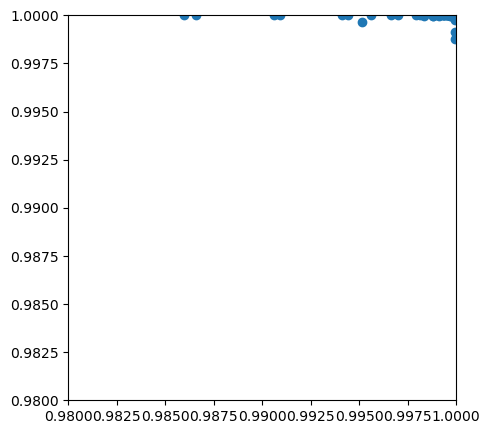

In [35]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_xlim([0.98, 1])
ax.set_ylim([0.98, 1])
ax.scatter(NN_array, bridge_array)